In [4]:
import MySQLdb as db
import pandas as pd
import matplotlib.pyplot as plt
% matplotlib inline

# Analytics Base Table

Dataframe contianing all data needed for modelling

In [36]:
# Read in csv containing ABT
df = pd.read_csv('ABT.csv')

In [35]:
df.head()

,DateTime,Room,Capacity,Module,NumReg,AvgNumWifiConn,PercentageEstimate,BinaryEstimate
0,2015-11-03 16:00:00,B-002,90,COMP40370P1,27,39.0000,0.25,1
1,2015-11-04 16:00:00,B-002,90,COMP30250P1,22,20.0000,0.25,1
2,2015-11-05 16:00:00,B-002,90,COMP30520P1,60,32.6667,0.00,0
3,2015-11-06 16:00:00,B-002,90,None,0,20.3333,0.50,1
4,2015-11-09 16:00:00,B-002,90,COMP40660P1,53,72.5000,0.25,1


In [8]:
df.dtypes

DateTime              datetime64[ns]
Room                          object
Capacity                       int64
Module                        object
NumReg                         int64
AvgNumWifiConn               float64
PercentageEstimate           float64
BinaryEstimate                 int64
dtype: object

In [9]:
df['Room'] = df['Room'].astype('category')
df['Module'] = df['Module'].astype('category')
df.dtypes

DateTime              datetime64[ns]
Room                        category
Capacity                       int64
Module                      category
NumReg                         int64
AvgNumWifiConn               float64
PercentageEstimate           float64
BinaryEstimate                 int64
dtype: object

In [10]:
df.corr()

,Capacity,NumReg,AvgNumWifiConn,PercentageEstimate,BinaryEstimate
Capacity,1.000000,0.468271,0.355578,-0.045083,-0.056617
NumReg,0.468271,1.000000,0.736217,0.344868,0.290085
AvgNumWifiConn,0.355578,0.736217,1.000000,0.598574,0.454588
PercentageEstimate,-0.045083,0.344868,0.598574,1.000000,0.769572
BinaryEstimate,-0.056617,0.290085,0.454588,0.769572,1.000000


## MODEL 2 - TARGET FEATURE EstimateNumPeople - HOW MANY PEOPLE IN THE ROOM?

Find how many people are in the room:
    EstimateNumPeople = Room capacity x percentage estimate {1}

This models predicts the number of people in the room but the predicted results are also used to find the predicted percentage of people in the room.

To find the percentage of people in the room the predictions (continuous values as this is a linear model) are divided by the capacity of the room (reverse of equation {1}). This will give us a percentage of people in the room. This percentage is then binned into the appropriate category (0.0, 0.25, 0.5, 0.75 or 1.0).

In [11]:
# add a column to the dataframe containing the estimate of the number of people in the room
df['EstimateNumPeople'] = df['Capacity'] * df['PercentageEstimate']
df.head()

,DateTime,Room,Capacity,Module,NumReg,AvgNumWifiConn,PercentageEstimate,BinaryEstimate,EstimateNumPeople
0,2015-11-03 16:00:00,B-002,90,COMP40370P1,27,39.0000,0.25,1,22.5
1,2015-11-04 16:00:00,B-002,90,COMP30250P1,22,20.0000,0.25,1,22.5
2,2015-11-05 16:00:00,B-002,90,COMP30520P1,60,32.6667,0.00,0,0.0
3,2015-11-06 16:00:00,B-002,90,None,0,20.3333,0.50,1,45.0
4,2015-11-09 16:00:00,B-002,90,COMP40660P1,53,72.5000,0.25,1,22.5


## Understanding data

In [12]:
# Look at correlations for all the continuous features.
df[['Capacity', 'NumReg', 'AvgNumWifiConn', 'EstimateNumPeople']].corr()

,Capacity,NumReg,AvgNumWifiConn,EstimateNumPeople
Capacity,1.000000,0.468271,0.355578,0.392960
NumReg,0.468271,1.000000,0.736217,0.562036
AvgNumWifiConn,0.355578,0.736217,1.000000,0.765715
EstimateNumPeople,0.392960,0.562036,0.765715,1.000000


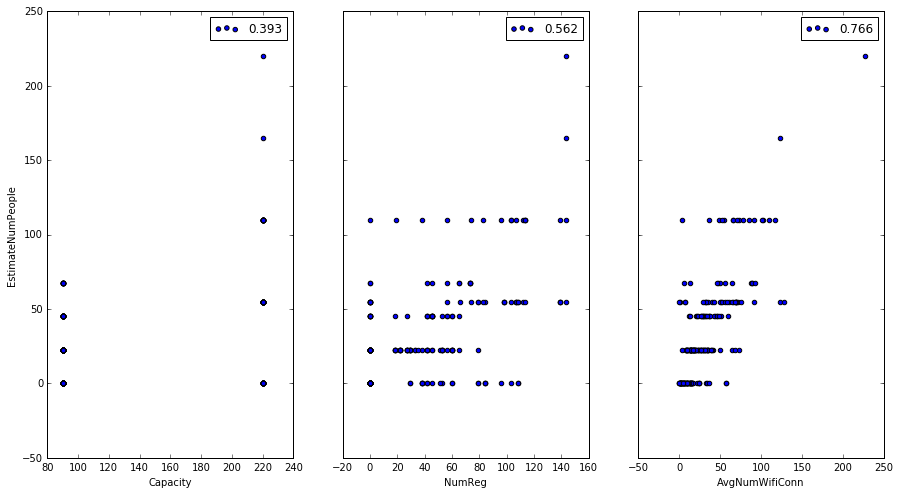

In [13]:
# Scatterplots for each descriptive feature and target feature. 
# Show the correlation value in the plot.
fig, axs = plt.subplots(1, 3, sharey = True)
df.plot(kind='scatter', x = 'Capacity', y = 'EstimateNumPeople', label="%.3f" % df[['Capacity', 'EstimateNumPeople']].corr().as_matrix()[0,1], ax = axs[0])
df.plot(kind='scatter', x = 'NumReg', y = 'EstimateNumPeople', label="%.3f" % df[['NumReg', 'EstimateNumPeople']].corr().as_matrix()[0,1], ax = axs[1])
df.plot(kind='scatter', x = 'AvgNumWifiConn', y = 'EstimateNumPeople', label="%.3f" % df[['AvgNumWifiConn', 'EstimateNumPeople']].corr().as_matrix()[0,1], ax = axs[2], figsize =(15,8))

# Linear regression with package statsmodel

## Multiple linear regression
### Training a model

In [14]:
#Import statsmodels package for training a linear regression model.
import statsmodels.formula.api as sm

# Train aka fit, a model using all features
lm = sm.ols(formula="EstimateNumPeople ~  Capacity + NumReg + AvgNumWifiConn + C(Room) -1 + C(DateTime)-1 + C(Module)-1", data=df).fit()

# Print the weights learned for each feature.
print(lm.params)

C(Room)[B-002]                                     -0.547293
C(Room)[B-003]                                      3.094262
C(Room)[B-004]                                     -1.041496
C(DateTime)[T.Timestamp('2015-11-03 10:00:00')]    36.819507
C(DateTime)[T.Timestamp('2015-11-03 11:00:00')]    19.589816
C(DateTime)[T.Timestamp('2015-11-03 12:00:00')]    18.172895
C(DateTime)[T.Timestamp('2015-11-03 13:00:00')]     3.463484
C(DateTime)[T.Timestamp('2015-11-03 14:00:00')]     2.533708
C(DateTime)[T.Timestamp('2015-11-03 15:00:00')]    -3.114917
C(DateTime)[T.Timestamp('2015-11-03 16:00:00')]   -21.078617
C(DateTime)[T.Timestamp('2015-11-04 09:00:00')]    25.862027
C(DateTime)[T.Timestamp('2015-11-04 10:00:00')]   -12.261719
C(DateTime)[T.Timestamp('2015-11-04 11:00:00')]   -13.201744
C(DateTime)[T.Timestamp('2015-11-04 12:00:00')]   -15.277871
C(DateTime)[T.Timestamp('2015-11-04 13:00:00')]   -33.160981
C(DateTime)[T.Timestamp('2015-11-04 14:00:00')]   -29.734796
C(DateTime)[T.Timestamp(

In [15]:
# Print the summary of the trained model.
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:      EstimateNumPeople   R-squared:                       0.838
Model:                            OLS   Adj. R-squared:                  0.603
Method:                 Least Squares   F-statistic:                     3.573
Date:                Sat, 16 Jul 2016   Prob (F-statistic):           7.00e-10
Time:                        14:14:54   Log-Likelihood:                -875.50
No. Observations:                 216   AIC:                             2007.
Df Residuals:                      88   BIC:                             2439.
Df Model:                         127                                         
Covariance Type:            nonrobust                                         
                                                      coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------------

### Evaluating the model on training and test data
Split the dataset into a training set and a test set. Fit the model on the training set, evaluate both on the training and the test set. Compare the prediction error on both sets.

In [16]:
# Take the first 3/4 as training data
df_train = df[:162]
df_train.head()

,DateTime,Room,Capacity,Module,NumReg,AvgNumWifiConn,PercentageEstimate,BinaryEstimate,EstimateNumPeople
0,2015-11-03 16:00:00,B-002,90,COMP40370P1,27,39.0000,0.25,1,22.5
1,2015-11-04 16:00:00,B-002,90,COMP30250P1,22,20.0000,0.25,1,22.5
2,2015-11-05 16:00:00,B-002,90,COMP30520P1,60,32.6667,0.00,0,0.0
3,2015-11-06 16:00:00,B-002,90,None,0,20.3333,0.50,1,45.0
4,2015-11-09 16:00:00,B-002,90,COMP40660P1,53,72.5000,0.25,1,22.5


In [17]:
# Take the last 1/4 rows as test data
df_test = df[162:]
df_test.head()

,DateTime,Room,Capacity,Module,NumReg,AvgNumWifiConn,PercentageEstimate,BinaryEstimate,EstimateNumPeople
162,2015-11-03 12:00:00,B-004,220,COMP30080,139,110.0000,0.50,1,110.0
163,2015-11-04 12:00:00,B-004,220,COMP20130,74,72.6000,0.50,1,110.0
164,2015-11-05 12:00:00,B-004,220,COMP20070,107,50.1667,0.25,1,55.0
165,2015-11-06 12:00:00,B-004,220,None,0,1.5000,0.25,1,55.0
166,2015-11-09 12:00:00,B-004,220,COMP20020,98,66.3333,0.25,1,55.0


In [ ]:
# mix up rows
# df = df.iloc[np.random.permutation(len(df))].reset_index(drop=True)
# split into training and test
# from sklearn.cross_validation import train_test_split
# df_train, df_test = train_test_split(df, test_size = 0.2)

## Training on df_train

In [18]:
# Train aka fit, a model using all features.
lm = sm.ols(formula="EstimateNumPeople ~  Capacity + NumReg + AvgNumWifiConn + C(Room) -1 + C(DateTime) -1 + C(Module)-1", data=df_train).fit()

# Print the weights learned for each feature.
print(lm.params)

C(Room)[B-002]                                    -7.348709e+00
C(Room)[B-003]                                    -7.617754e+00
C(Room)[B-004]                                     6.123644e+00
C(DateTime)[T.Timestamp('2015-11-03 10:00:00')]    5.137328e+01
C(DateTime)[T.Timestamp('2015-11-03 11:00:00')]    4.080148e+01
C(DateTime)[T.Timestamp('2015-11-03 12:00:00')]    3.062430e+01
C(DateTime)[T.Timestamp('2015-11-03 13:00:00')]   -4.186078e+00
C(DateTime)[T.Timestamp('2015-11-03 14:00:00')]    3.728873e+01
C(DateTime)[T.Timestamp('2015-11-03 15:00:00')]    8.223346e+00
C(DateTime)[T.Timestamp('2015-11-03 16:00:00')]   -2.571778e+00
C(DateTime)[T.Timestamp('2015-11-04 09:00:00')]    1.618745e+01
C(DateTime)[T.Timestamp('2015-11-04 10:00:00')]   -2.909361e+01
C(DateTime)[T.Timestamp('2015-11-04 11:00:00')]   -2.445962e+01
C(DateTime)[T.Timestamp('2015-11-04 12:00:00')]    1.310322e+01
C(DateTime)[T.Timestamp('2015-11-04 13:00:00')]    1.311945e+00
C(DateTime)[T.Timestamp('2015-11-04 14:0

In [19]:
# Print the detailed metrics for the trained model.
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:      EstimateNumPeople   R-squared:                       0.859
Model:                            OLS   Adj. R-squared:                  0.528
Method:                 Least Squares   F-statistic:                     2.596
Date:                Sat, 16 Jul 2016   Prob (F-statistic):           0.000167
Time:                        14:15:11   Log-Likelihood:                -588.19
No. Observations:                 162   AIC:                             1404.
Df Residuals:                      48   BIC:                             1756.
Df Model:                         113                                         
Covariance Type:            nonrobust                                         
                                                      coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------------

## Testing on df_train

In [21]:
# test on df_train
lm.predict(df_train)

array([  2.23892122e+01,   1.23894990e+01,   5.53337291e+00,
         4.63689798e+01,   2.25000000e+01,   2.26107878e+01,
         3.26105010e+01,   1.91573101e+01,   2.11151906e+01,
         1.66181682e-01,   2.24778462e+01,  -8.70444276e-01,
        -6.33717736e+00,   2.25000000e+01,  -1.50352142e-01,
         2.25221538e+01,   8.70444276e-01,   6.33717736e+00,
         6.16021761e+01,   1.31621120e+01,   2.19634897e+01,
         1.98887406e+01,   3.35913645e+01,   1.23190224e+00,
        -1.75347649e+00,   2.77024320e+01,  -1.98887406e+01,
         5.42934983e+01,   8.96160266e+00,   2.37924973e+01,
         2.52017100e+01,  -4.66116035e-12,   1.90609873e+01,
         3.38883177e+01,   2.44044336e+01,  -2.02434432e+00,
         3.11544730e+01,   3.92072373e+01,   2.79357263e+01,
         1.65964542e+01,   2.46500797e+01,   3.31485962e+01,
         2.82927627e+01,   1.12097881e+01,   5.22618011e+00,
         2.84865248e-01,   6.16309041e+00,   2.09490184e+01,
         1.65109965e+01,

In [56]:
# PREDICTIONS (TRAINING) : ESTIMATE OF NUMBER OF PEOPLE

# look at the actual values and the predicted values beside one another
fmt = '{:<8}{:<8}{}'
print(fmt.format('', 'Actual', 'Predicted'))
for i, (act, pred) in enumerate(zip(list(df_train.EstimateNumPeople), lm.predict(df_train))):
    print(fmt.format(i, act, pred))

        Actual  Predicted
0       22.5    22.38921221211145
1       22.5    12.38949897552638
2       0.0     5.533372910980635
3       45.0    46.368979825459206
4       22.5    22.500000000003276
5       22.5    22.610787787906997
6       22.5    32.610501024477344
7       22.5    19.157310118339456
8       22.5    21.115190634605632
9       0.0     0.1661816818386299
10      22.5    22.477846240750644
11      0.0     -0.8704442757564124
12      0.0     -6.337177363878162
13      22.5    22.500000000006807
14      0.0     -0.1503521419105347
15      22.5    22.52215375924868
16      0.0     0.8704442757489339
17      0.0     6.3371773638795865
18      45.0    61.60217606549332
19      22.5    13.16211195486105
20      45.0    21.963489706966108
21      0.0     19.888740603623674
22      22.5    33.59136453838716
23      0.0     1.2319022389033556
24      0.0     -1.7534764932520588
25      22.5    27.70243198863198
26      0.0     -19.88874060361584
27      45.0    54.29349827574221


In [50]:
# PREDICTIONS (TRAINING) : PERCENTAGE ESTIMATE (RANGE : 0-100%)

# Get predicted values
predictions_train =  lm.predict(df_train)

# Find the percentage occupancy (values ranging from 0-100%)
# list to hold percentage predictions
predictions_train_per = [0 for i in range(0, len(predictions_train))]
for i in range(0, len(predictions_train)):
    predictions_train_per[i] = predictions_train[i] / df['Capacity'][i]

# look at the actual values and the predicted values beside one another
fmt = '{:<8}{:<8}{}'
print(fmt.format('', 'Actual', 'Predicted'))
for i, (act, pred) in enumerate(zip(list(df_train.PercentageEstimate), predictions_train_per)):
    print(fmt.format(i, act, pred))

        Actual  Predicted
0       0.25    0.2487690245790161
1       0.25    0.1376610997280709
2       0.0     0.061481921233118166
3       0.5     0.5152108869495468
4       0.25    0.2500000000000364
5       0.25    0.25123097542118883
6       0.25    0.36233890027197047
7       0.25    0.21285900131488283
8       0.25    0.23461322927339592
9       0.0     0.0018464631315403325
10      0.25    0.2497538471194516
11      0.0     -0.009671603063960137
12      0.0     -0.07041308182086846
13      0.25    0.2500000000000756
14      0.0     -0.0016705793545614966
15      0.25    0.2502461528805409
16      0.0     0.009671603063877043
17      0.0     0.0704130818208843
18      0.5     0.6844686229499257
19      0.25    0.146245688387345
20      0.5     0.24403877452184564
21      0.0     0.22098600670692972
22      0.25    0.3732373837598573
23      0.0     0.013687802654481728
24      0.0     -0.0194830721472451
25      0.25    0.30780479987368864
26      0.0     -0.22098600670684268
27

In [55]:
# PREDICTIONS (TRAINING) : BINNED PERCENTAGE ESTIMATE (0,0.25,0.5,0.75,1.0)

# list to hold binned percentage predictions
predictions_train_per_binned = [0 for i in range(0, len(predictions_train_per))]

# bin percentage results into 0.0, 0.25, 0.5, 0.75 or 1.0
for i in range(0, len(predictions_train_per)):
    if min(predictions_train_per) <= predictions_train_per[i] < 0.125:
        predictions_train_per_binned[i] = 0.0
    elif 0.125 <= predictions_train_per[i] < 0.375:
        predictions_train_per_binned[i] = 0.25
    elif 0.375 <= predictions_train_per[i] < 0.625:
        predictions_train_per_binned[i] = 0.5
    elif 0.625 <= predictions_train_per[i] < 0.875:
        predictions_train_per_binned[i] = 0.75
    else:
        predictions_train_per_binned[i] = 1.0

# look at the actual values and the predicted values beside one another
fmt = '{:<8}{:<8}{}'
print(fmt.format('', 'Actual', 'Predicted'))
for i, (act, pred) in enumerate(zip(list(df_train.PercentageEstimate), predictions_train_per_binned)):
    print(fmt.format(i, act, pred))

        Actual  Predicted
0       0.25    0.25
1       0.25    0.25
2       0.0     0.0
3       0.5     0.5
4       0.25    0.25
5       0.25    0.25
6       0.25    0.25
7       0.25    0.25
8       0.25    0.25
9       0.0     0.0
10      0.25    0.25
11      0.0     0.0
12      0.0     0.0
13      0.25    0.25
14      0.0     0.0
15      0.25    0.25
16      0.0     0.0
17      0.0     0.0
18      0.5     0.75
19      0.25    0.25
20      0.5     0.25
21      0.0     0.25
22      0.25    0.25
23      0.0     0.0
24      0.0     0.0
25      0.25    0.25
26      0.0     0.0
27      0.5     0.5
28      0.25    0.0
29      0.25    0.25
30      0.25    0.25
31      0.0     0.0
32      0.25    0.25
33      0.25    0.5
34      0.25    0.25
35      0.0     0.0
36      0.5     0.25
37      0.5     0.5
38      0.25    0.25
39      0.25    0.25
40      0.25    0.25
41      0.25    0.25
42      0.25    0.25
43      0.25    0.0
44      0.0     0.0
45      0.0     0.0
46      0.0     0.0
47      

In [23]:
# Pair the actual and the predicted values
print("Actual - Predicted:\n", (df_train.EstimateNumPeople - lm.predict(df_train)))
print("\n(Actual - Predicted) squared:\n", (df_train.EstimateNumPeople - lm.predict(df_train))**2)

Actual - Predicted:
 0      1.107878e-01
1      1.011050e+01
2     -5.533373e+00
3     -1.368980e+00
4     -3.275602e-12
5     -1.107878e-01
6     -1.011050e+01
7      3.342690e+00
8      1.384809e+00
9     -1.661817e-01
10     2.215376e-02
11     8.704443e-01
12     6.337177e+00
13    -6.806999e-12
14     1.503521e-01
15    -2.215376e-02
16    -8.704443e-01
17    -6.337177e+00
18    -1.660218e+01
19     9.337888e+00
20     2.303651e+01
21    -1.988874e+01
22    -1.109136e+01
23    -1.231902e+00
24     1.753476e+00
25    -5.202432e+00
26     1.988874e+01
27    -9.293498e+00
28     1.353840e+01
29    -1.292497e+00
           ...     
132    2.141442e+01
133    2.526936e+00
134    1.347692e+01
135   -1.384553e+01
136   -5.792763e+00
137    5.435726e+00
138   -5.903546e+00
139    2.150080e+00
140    1.064860e+01
141    5.792763e+00
142   -1.129021e+01
143    5.226180e+00
144    2.018525e+00
145   -1.379364e+01
146   -2.421904e+01
147    3.273730e+01
148    1.109136e+01
149   -2.018525e+00

In [24]:
# Print the Mean Squared Error of the model on the training set
mse = ((df_train.EstimateNumPeople - lm.predict(df_train))** 2).mean()
print("\nMean Squared Error:\n", mse)


Mean Squared Error:
 83.4017415601


In [25]:
print("|Actual - Predicted|:\n", abs(df_train.EstimateNumPeople - lm.predict(df_train)))


|Actual - Predicted|:
 0      1.107878e-01
1      1.011050e+01
2      5.533373e+00
3      1.368980e+00
4      3.275602e-12
5      1.107878e-01
6      1.011050e+01
7      3.342690e+00
8      1.384809e+00
9      1.661817e-01
10     2.215376e-02
11     8.704443e-01
12     6.337177e+00
13     6.806999e-12
14     1.503521e-01
15     2.215376e-02
16     8.704443e-01
17     6.337177e+00
18     1.660218e+01
19     9.337888e+00
20     2.303651e+01
21     1.988874e+01
22     1.109136e+01
23     1.231902e+00
24     1.753476e+00
25     5.202432e+00
26     1.988874e+01
27     9.293498e+00
28     1.353840e+01
29     1.292497e+00
           ...     
132    2.141442e+01
133    2.526936e+00
134    1.347692e+01
135    1.384553e+01
136    5.792763e+00
137    5.435726e+00
138    5.903546e+00
139    2.150080e+00
140    1.064860e+01
141    5.792763e+00
142    1.129021e+01
143    5.226180e+00
144    2.018525e+00
145    1.379364e+01
146    2.421904e+01
147    3.273730e+01
148    1.109136e+01
149    2.018525e+

In [26]:
# Print the Mean Absolute Error of the model on the training set
mae = abs(df_train.EstimateNumPeople - lm.predict(df_train)).mean()
print("\nMean Absolute Error on training:\n", mae)


Mean Absolute Error on training:
 6.43162222237


## Testing on df_test

In [27]:
[df_test.EstimateNumPeople, lm.predict(df_test)]

[162    110.0
 163    110.0
 164     55.0
 165     55.0
 166     55.0
 167     55.0
 168     55.0
 169     55.0
 170      0.0
 171    110.0
 172      0.0
 173    110.0
 174    110.0
 175     55.0
 176     55.0
 177      0.0
 178    110.0
 179      0.0
 180     55.0
 181      0.0
 182     55.0
 183     55.0
 184     55.0
 185    110.0
 186      0.0
 187    110.0
 188    110.0
 189     55.0
 190      0.0
 191      0.0
 192      0.0
 193    110.0
 194     55.0
 195      0.0
 196     55.0
 197    110.0
 198      0.0
 199      0.0
 200      0.0
 201      0.0
 202     55.0
 203      0.0
 204      0.0
 205      0.0
 206      0.0
 207    165.0
 208     55.0
 209    220.0
 210      0.0
 211     55.0
 212     55.0
 213      0.0
 214    110.0
 215      0.0
 Name: EstimateNumPeople, dtype: float64,
 array([  84.46617306,   83.89692218,   68.07682771,   43.39419717,
          59.26964125,   71.77340792,   70.60214824,   54.83266652,
          33.02413727,   55.54485325,   48.44063525,   86.83238558

In [57]:
# PREDICTIONS (TEST) : ESTIMATE OF NUMBER OF PEOPLE

# look at the actual values and the predicted values beside one another
fmt = '{:<8}{:<8}{}'
print(fmt.format('', 'Actual', 'Predicted'))
for i, (act, pred) in enumerate(zip(list(df_test.EstimateNumPeople), lm.predict(df_test))):
    print(fmt.format(i, act, pred))

        Actual  Predicted
0       110.0   84.46617306012453
1       110.0   83.89692217594428
2       55.0    68.07682770703339
3       55.0    43.39419716891658
4       55.0    59.26964124616829
5       55.0    71.77340792164608
6       55.0    70.60214823931152
7       55.0    54.83266651656558
8       0.0     33.02413726946597
9       110.0   55.54485325101847
10      0.0     48.44063524581066
11      110.0   86.83238557906617
12      110.0   58.0108867119417
13      55.0    56.31080110625573
14      55.0    79.62748438647643
15      0.0     57.34835711831821
16      110.0   62.93951900632983
17      0.0     37.13210137710329
18      55.0    120.57956322367541
19      0.0     27.175481337704852
20      55.0    106.51499578779676
21      55.0    122.71226484866104
22      55.0    75.80410039913342
23      110.0   98.76009100350875
24      0.0     36.60228297686353
25      110.0   110.67476727898227
26      110.0   112.04999942858778
27      55.0    68.56862926791304
28      0.0     -

In [58]:
# PREDICTIONS (TEST) : PERCENTAGE ESTIMATE (RANGE : 0-100%)

# Get predicted values
predictions_test =  lm.predict(df_test)

# Find the percentage occupancy (values ranging from 0-100%)
# list to hold percentage predictions
predictions_test_per = [0 for i in range(0, len(predictions_test))]
for i in range(0, len(predictions_test)):
    predictions_test_per[i] = predictions_test[i] / df['Capacity'][i]

# look at the actual values and the predicted values beside one another
fmt = '{:<8}{:<8}{}'
print(fmt.format('', 'Actual', 'Predicted'))
for i, (act, pred) in enumerate(zip(list(df_test.PercentageEstimate), predictions_test_per)):
    print(fmt.format(i, act, pred))

        Actual  Predicted
0       0.5     0.9385130340013836
1       0.5     0.9321880241771587
2       0.25    0.7564091967448154
3       0.25    0.4821577463212953
4       0.25    0.6585515694018699
5       0.25    0.7974823102405121
6       0.25    0.7844683137701279
7       0.25    0.609251850184062
8       0.0     0.3669348585496219
9       0.5     0.6171650361224275
10      0.0     0.5382292805090073
11      0.5     0.9648042842118463
12      0.5     0.6445654079104634
13      0.25    0.625675567847286
14      0.25    0.8847498265164048
15      0.0     0.6372039679813135
16      0.5     0.6993279889592203
17      0.0     0.41257890419003657
18      0.25    1.3397729247075045
19      0.0     0.301949792641165
20      0.25    1.183499953197742
21      0.25    1.363469609429567
22      0.25    0.8422677822125936
23      0.5     1.0973343444834305
24      0.0     0.4066920330762614
25      0.5     1.2297196364331364
26      0.5     1.2449999936509752
27      0.25    0.761873658532367

In [59]:
# PREDICTIONS (TEST) : BINNED PERCENTAGE ESTIMATE (0,0.25,0.5,0.75,1.0)

# list to hold binned percentage predictions
predictions_test_per_binned = [0 for i in range(0, len(predictions_test_per))]

# bin percentage results into 0.0, 0.25, 0.5, 0.75 or 1.0
for i in range(0, len(predictions_test_per)):
    if min(predictions_test_per) <= predictions_test_per[i] < 0.125:
        predictions_test_per_binned[i] = 0.0
    elif 0.125 <= predictions_test_per[i] < 0.375:
        predictions_test_per_binned[i] = 0.25
    elif 0.375 <= predictions_test_per[i] < 0.625:
        predictions_test_per_binned[i] = 0.5
    elif 0.625 <= predictions_test_per[i] < 0.875:
        predictions_test_per_binned[i] = 0.75
    else:
        predictions_test_per_binned[i] = 1.0

# look at the actual values and the predicted values beside one another
fmt = '{:<8}{:<8}{}'
print(fmt.format('', 'Actual', 'Predicted'))
for i, (act, pred) in enumerate(zip(list(df_test.PercentageEstimate), predictions_test_per_binned)):
    print(fmt.format(i, act, pred))

        Actual  Predicted
0       0.5     1.0
1       0.5     1.0
2       0.25    1.0
3       0.25    0.5
4       0.25    1.0
5       0.25    1.0
6       0.25    1.0
7       0.25    0.5
8       0.0     0.25
9       0.5     0.5
10      0.0     0.5
11      0.5     1.0
12      0.5     1.0
13      0.25    1.0
14      0.25    1.0
15      0.0     1.0
16      0.5     1.0
17      0.0     0.5
18      0.25    0.75
19      0.0     0.25
20      0.25    1.0
21      0.25    1.0
22      0.25    1.0
23      0.5     1.0
24      0.0     0.5
25      0.5     1.0
26      0.5     1.0
27      0.25    1.0
28      0.0     1.0
29      0.0     0.5
30      0.0     1.0
31      0.5     1.0
32      0.25    1.0
33      0.0     0.25
34      0.25    0.5
35      0.5     1.0
36      0.0     0.5
37      0.0     0.5
38      0.0     0.25
39      0.0     1.0
40      0.25    0.5
41      0.0     0.5
42      0.0     1.0
43      0.0     0.5
44      0.0     1.0
45      0.75    1.0
46      0.25    1.0
47      1.0     1.0
48      0

In [41]:
# Print the Mean Squared Error of the model on the test set
mse = ((df_test.EstimateNumPeople - lm.predict(df_test))** 2).mean()
print("\nMean Squared Error on test:\n", mse)

# Print the Mean Absolute Error of the model on the test set
mae = abs(df_test.EstimateNumPeople - lm.predict(df_test)).mean()
print("\nMean Absolute Error on test:\n", mae)



Mean Squared Error on test:
 1858.18755277

Mean Absolute Error on test:
 34.742987765


## Model evaluation: Training versus test error

In [42]:
# Print the Mean Absolute Error of the model on the training set
mae = abs(df_train.EstimateNumPeople - lm.predict(df_train)).mean()
print("\nMean Absolute Error on training:\n", mae)

# Print the Mean Absolute Error of the model on the test set
mae = abs(df_test.EstimateNumPeople - lm.predict(df_test)).mean()
print("\nMean Absolute Error on test:\n", mae)

# Overfitting ?? try another model with less features??



Mean Absolute Error on training:
 6.43162222237

Mean Absolute Error on test:
 34.742987765
